In [ ]:
# !pip install tab2img

In [1]:
!pip install scikit-learn==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install xgboost==0.81

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.6 MB 4.3 MB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
# To connect to my Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Dropout 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.utils import to_categorical

# from tab2img.converter import Tab2Img
from xgboost import XGBClassifier

# **Read CSV files**

In [ ]:
#Import CSV dataset file (read) from my Google Drive
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Shipping/Multicriteria_Code/Multicriteria_Code_Project_2/MLCD_Project2_With_Specific_attribute/MCDM_Project2_Only_Container/dataset.csv', encoding= 'unicode_escape')

print("\nFeatures Name")
print("==================\n")
print(list(df.columns))


Features Name

['Category of Trade', 'Volume Type', 'Load Port', 'Discharge Port', 'Dangerous Goods', 'Organisation']


# **Seperate features and target**

In [ ]:
# seperate features and target column
features = ["Category of Trade", "Volume Type", "Load Port", "Discharge Port", "Dangerous Goods"]
target = "Organisation"

# copy the feqatures and class dataframe in X and y variable
X = df[features]
y = df[target]

# **Scale features and train test split**

In [ ]:
# scalling feature value between the range of 0-1
ss = StandardScaler()
X = ss.fit_transform(X)


## customize functions

In [ ]:
#list of evaluation scores
evalution_scores = []

# save saller
pkl_file = open('/content/drive/MyDrive/Shipping/Multicriteria_Code/Multicriteria_Code_Project_2/MLCD_Project2_With_Specific_attribute/MCDM_Project2_Only_Container/target_encoder.pkl', 'rb')
le_target = pickle.load(pkl_file) 

# function for getting class labels via class integar using label encoder
def get_classes(y_test):
    y_test = y_test.unique()
    print(len(y_test))
    return le_target.inverse_transform(y_test)

# get unique classes in test set
def get_str_classes(y_test):
    y_test = y_test.unique()
    return [str(int) for int in y_test]

# split dataset in training and testing set 
def get_train_test_split():
    return train_test_split(X, y, test_size=0.2, random_state=42)


# split data into train, test and validation set with splitted feature and class
def get_train_test_val_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=2)
    return X_train, X_test, X_val, y_train, y_test, y_val

# split data into train, test and validation set with joined feature and class
def get_train_test_val_split_df():
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=2)
    return train, test, val


# compute the accuracy using true and predicted labels
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy


# compute other evaluation measures and print
def make_predictions(y_test, y_pred):
    accuracy=accuracy_score(y_test, y_pred)
    P, R, F, S = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    
    accuracy = "{:.4f}".format(accuracy)
    P = "{:.4f}".format(P)
    R = "{:.4f}".format(R)
    F = "{:.4f}".format(F)

    print("Accuracy Score :", accuracy)
    print("=======================\n")

    print("Precision Score :", P)
    print("========================\n")

    print("Recall Score :", R)
    print("=====================\n")

    print("F1 Score :", F)
    print("=================\n")

    return accuracy, P, R, F


# convert the vector input into matrix for deep leaning model
def DL_preprocessing(train, target):
    target = target.to_numpy()
    model = Tab2Img()
    images = model.fit_transform(train, target)
    
    size = (200, 200)
    reshaped_images = []
    for img in images:
        img = np.resize(img, (img.shape[0], img.shape[1], 3))
        reshaped_images.append(tf.keras.preprocessing.image.smart_resize(
            img, size, interpolation='bilinear'
        ))
    reshaped_images = np.array(reshaped_images)
    target = tf.keras.utils.to_categorical(target, 81)
    return reshaped_images, target

# plot graph of accuracy and loss using history object
def plot_graph(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# **Machine Learning Models**
## **Random Forest**

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (4115, 5)

 shape of training labels : (4115,)

 shape of testing features : (1029, 5)

 shape of testing labels : (1029,)


<BarContainer object of 5 artists>

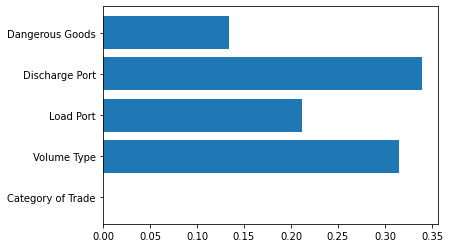

In [ ]:
# model initialization
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
# model training
clf = clf.fit(X_train, y_train)
plt.barh(features, clf.feature_importances_)

In [ ]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["Random Forest", Acc, P, R, F])

Accuracy Score : 0.7123

Precision Score : 0.6456

Recall Score : 0.7123

F1 Score : 0.6583



## **XG Boost**

In [ ]:
# train test split
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (4115, 5)

 shape of training labels : (4115,)

 shape of testing features : (1029, 5)

 shape of testing labels : (1029,)


<BarContainer object of 5 artists>

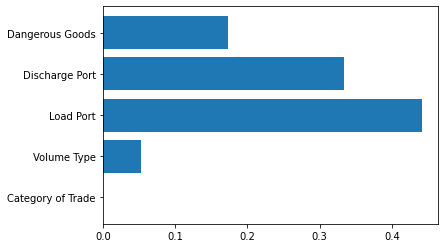

In [ ]:
# model initialization
clf = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=3)
# model training
clf = clf.fit(X_train, y_train)
plt.barh(features, clf.feature_importances_)

In [ ]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["XG Boost", Acc, P, R, F])

Accuracy Score : 0.7891

Precision Score : 0.7888

Recall Score : 0.7891

F1 Score : 0.7685



## **SVM Model**

In [ ]:
# model initialization
clf = svm.SVC(kernel='rbf', gamma=1, C=0.5)
# model training
clf = clf.fit(X_train, y_train)
# plt.barh(features, clf.coef_)

In [ ]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["SVM", Acc, P, R, F])

Accuracy Score : 0.7736

Precision Score : 0.8046

Recall Score : 0.7736

F1 Score : 0.7651



## **KNN Model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# model initialization
clf = KNeighborsClassifier(n_neighbors=6, p=1, leaf_size=3)
# model training
clf = clf.fit(X_train, y_train)
# plt.barh(features, clf.coef_)

In [ ]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["KNN", Acc, P, R, F])

Accuracy Score : 0.7075

Precision Score : 0.7178

Recall Score : 0.7075

F1 Score : 0.6629



## Customize Model 1

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(X, y)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (3610, 5)

 shape of training labels : (3610,)

 shape of testing features : (515, 5)

 shape of testing labels : (515,)

 shape of validation features : (1019, 5)

 shape of validation labels : (1019,)


In [ ]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_dim=5,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dropout(0.5))

RF_X_train = model.predict(X_train)
RF_X_test = model.predict(X_test)

In [ ]:
# model initialization
clf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=1)
# model training
clf = clf.fit(RF_X_train, y_train)

In [ ]:
# model predictions
y_pred = clf.predict(RF_X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["customize 1", Acc, P, R, F])

Accuracy Score : 0.7553

Precision Score : 0.7575

Recall Score : 0.7553

F1 Score : 0.7364



## Customize 2

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(random_state = 1, max_depth = 15, n_estimators = 500, min_samples_split = 2, min_samples_leaf = 1)
clf2 = XGBClassifier(learning_rate=0.2, n_estimators=700, max_depth=5)
clf3 = KNeighborsClassifier(leaf_size=5, p=1, n_neighbors=7)

eclf = VotingClassifier(estimators=[('rf', clf1), ('cgb', clf2), ('knn', clf3)], voting='soft', weights=[1, 1, 1])
eclf = eclf.fit(X_train, y_train)

In [ ]:
# model predictions
y_pred = eclf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["customize 2", Acc, P, R, F])

Accuracy Score : 0.7930

Precision Score : 0.7905

Recall Score : 0.7930

F1 Score : 0.7748



In [ ]:
evaluation_df = pd.DataFrame(evalution_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
evaluation_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.7123,0.6456,0.7123,0.6583
1,XG Boost,0.7891,0.7888,0.7891,0.7685
2,SVM,0.7736,0.8046,0.7736,0.7651
3,KNN,0.7075,0.7178,0.7075,0.6629
4,customize 2,0.7930,0.7905,0.7930,0.7748


## predict 4 Best Service Providers

In [ ]:
# load and return dictionary of label encoders
def get_label_encoders():
    columns = ["Category of Trade", "Volume Type",
               "Load Port", "Discharge Port", "Dangerous Goods"]

    le_dict = open("/content/drive/MyDrive/Shipping/Multicriteria_Code/Multicriteria_Code_Project_2/MLCD_Project2_With_Specific_attribute/MCDM_Project2_Only_DryBulk/le_dict.pickle",'rb')
    le_dict = pickle.load(le_dict)
    
    le_target = open("/content/drive/MyDrive/Shipping/Multicriteria_Code/Multicriteria_Code_Project_2/MLCD_Project2_With_Specific_attribute/MCDM_Project2_Only_DryBulk/target_encoder.pkl",'rb')
    le_target = pickle.load(le_target)
    return le_dict, le_target, columns

# convert the integral value of class into its label
def tranform_label(le_dict, le_dict_name, val):
    return le_dict[le_dict_name].transform([val])[0]

# display the best four service providers on screen
def display_output(le_target, indices):
    print("\nName of the Best 4 Service Providers :")
    print("====================================\n")
    for idx, indice in enumerate(indices):
        SP = le_target.inverse_transform([indice])
        print(idx, "--> ", SP[0], "\n")
    print("\n")

In [ ]:
# sample 
feature_list = ["Dry Bulk", "MT", "Brisbane", "Darwin", "No"]

# list for appending encoded values of sample
le_features = []
# get label encoders dictionary
le_dict, le_target, columns = get_label_encoders()

# convert string value into numerical bvalues using label encoders
for idx, val in enumerate(feature_list):
    le_dict_name = columns[idx]
    value = tranform_label(le_dict, le_dict_name, val) if le_dict_name in le_dict else int(val)
    le_features.append(value)

noramilzed_features = ss.transform(np.array(le_features).reshape(1, -1)) #normalized values
result = eclf.predict_proba(noramilzed_features) # predict normalized sample using trained model

In [ ]:
print("\nprobability of all Classes")
print("==========================\n")
print(result[0])


probability of all Classes

[3.46418601e-01 1.60505747e-03 4.68453283e-01 1.86957497e-04
 2.67277375e-04 4.77368693e-02 1.05588146e-03 1.22128396e-03
 4.72820985e-04 1.07298528e-04 3.55882669e-02 9.51436348e-04
 1.57359260e-04 2.18885237e-03 1.07116451e-02 1.20028172e-02
 1.19265914e-02 5.84394530e-02 5.45781901e-05 4.53676990e-04]


In [ ]:
print("\nprobability of all Classes in sorting order")
print("===========================================\n")
print((-result[0]).argsort())


probability of all Classes in sorting order

[ 2  0 17  5 10 15 16 14 13  1  7  6 11  8 19  4  3 12  9 18]


In [ ]:
# select the first four indices
n = 4
indices = (-result[0]).argsort()[:n]
print(indices)

[ 2  0 17  5]


In [ ]:
# convert the class integar into its label value using Label Encoder
display_output(le_target, indices)


Name of the Best 4 Service Providers :

0 -->  Alcoa Portland Aluminium 

1 -->  Adelaide Brighton Cement Ltd 

2 -->  Harvey Bay Pty Ltd 

3 -->  Asiaworld Shipping Service Pty Ltd 



